<a href="https://colab.research.google.com/github/0Sensei2/Deep-Learning/blob/main/DeepL(HyperParameter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install keras_preprocessing

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Resizing, Rescaling
from PIL import Image

from pathlib import Path
import os.path
import random
import datetime

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('white')

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [19]:

# Parameter
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Path dataset
dataset = "/content/drive/MyDrive/DeepL"

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(dirnames)} folder dan {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset)

Ada 4 folder dan 1 file di direktori: /content/drive/MyDrive/DeepL
Ada 0 folder dan 320 file di direktori: /content/drive/MyDrive/DeepL/Gitar
Ada 0 folder dan 322 file di direktori: /content/drive/MyDrive/DeepL/piano
Ada 0 folder dan 306 file di direktori: /content/drive/MyDrive/DeepL/Harmonika
Ada 0 folder dan 316 file di direktori: /content/drive/MyDrive/DeepL/Suling


In [20]:

image_dir = Path(dataset)

# Dapatkan jalur file dan label
filepaths = list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Jenis')

# Gabungkan jalur file dan label
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-21-b43f6afc3956>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


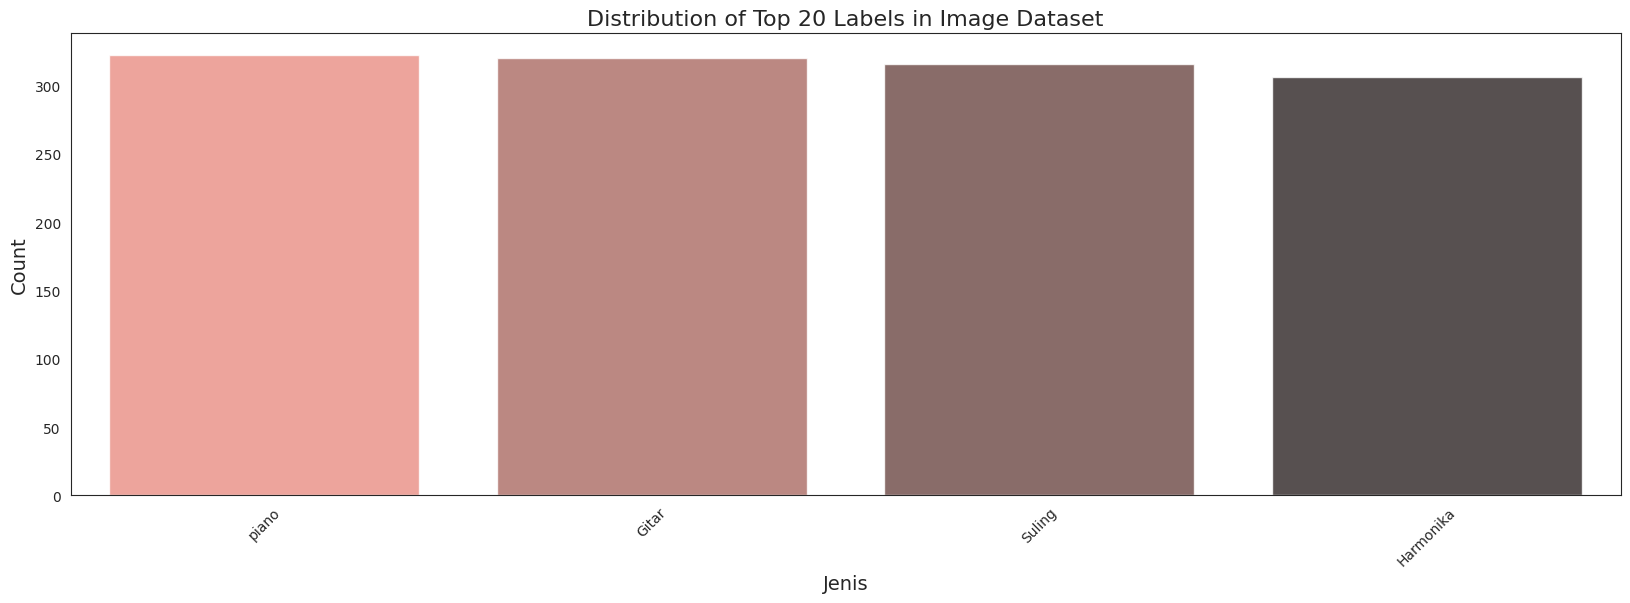

In [21]:

# Dapatkan 20 label teratas
label_counts = image_df['Jenis'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Jenis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [6]:
# Ambil 2 gambar acak dari tiap kelas
sample_df = image_df.groupby('Jenis', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)

# Plot gambar-gambar
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = sample_df.Filepath[i]
    label = sample_df.Jenis[i]

    # Membaca gambar dan mengubah ukuran menjadi persegi
    img = Image.open(img_path)
    img_resized = img.resize((224, 224))

    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.show()

<ipython-input-6-68f2e40aaac6>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_df.groupby('Jenis', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)


In [7]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Membaca gambar yang terkompres
    compressed_img = cv2.imread(temp_filename)

    # Dapatkan perbedaan absolut antara img1 dan img2 dan kalikan dengan skala
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    # Pilih gambar acak dari folder
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

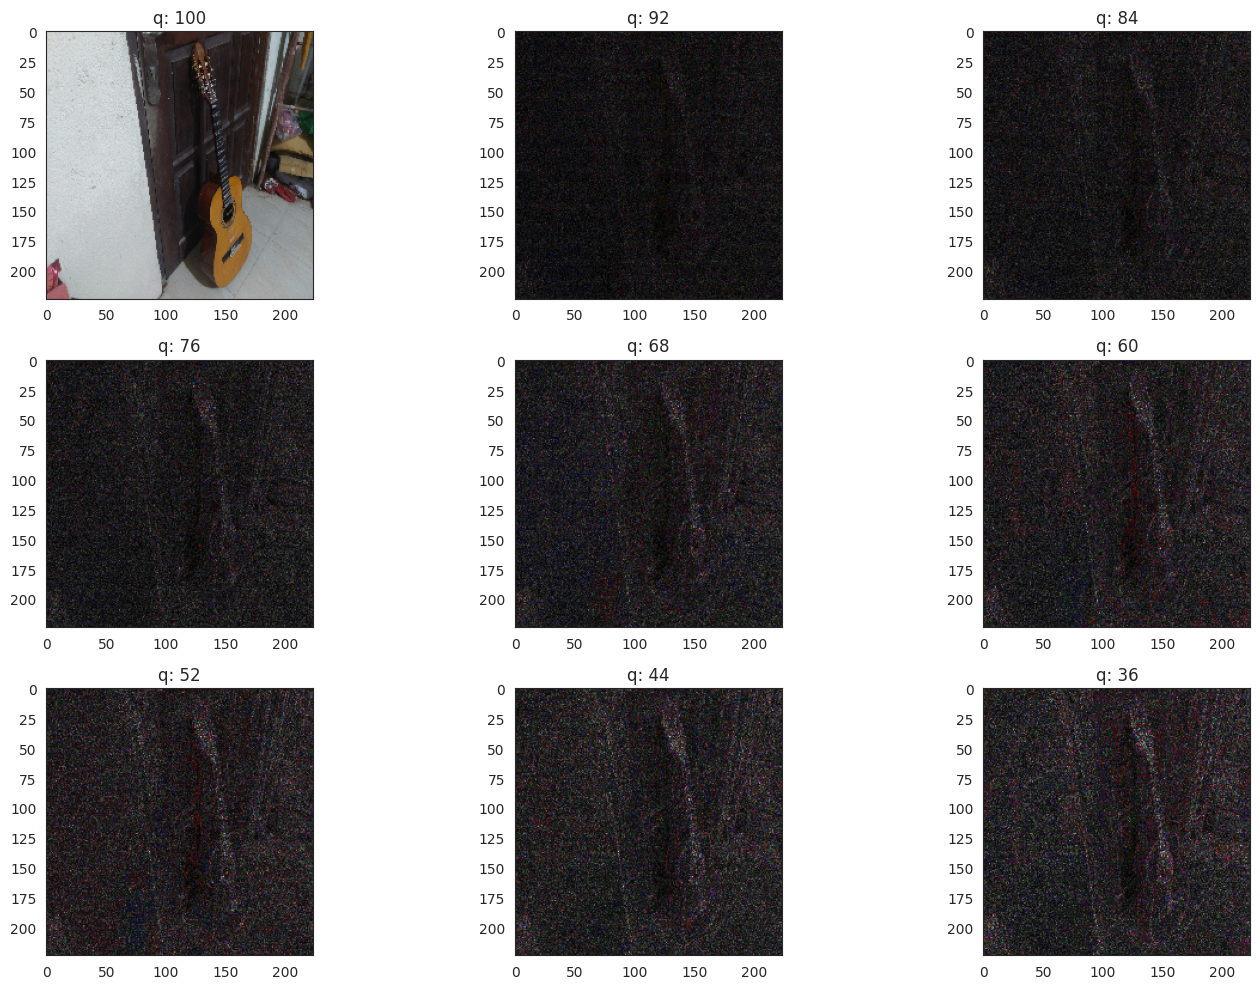

In [8]:
# Lihat sampel acak dari kumpulan data dan terapkan ELA
sample_class = 'Gitar'
dataset_path = '/content/drive/MyDrive/DeepL'
p = random_sample(f'{dataset_path}/{sample_class}')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# Inisialisasi parameter
init_val = 100
columns = 3
rows = 3

# Membuat figure untuk plot
fig = plt.figure(figsize=(15, 10))

for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8  # Menurunkan kualitas kompresi untuk setiap gambar
    img = compute_ela_cv(path=p, quality=quality)

    if i == 1:
        img = orig.copy()  # Gambar asli di posisi pertama

    # Mengubah ukuran gambar menjadi persegi
    img_resized = cv2.resize(img, (224, 224))  # Ganti 92 dengan ukuran yang diinginkan

    # Menambahkan gambar yang telah diresize ke dalam subplot
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img_resized)

plt.tight_layout()
plt.show()

In [10]:
train_val_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42, stratify=image_df['Jenis'])

train_df, val_df = train_test_split(train_val_df, test_size=0.25, shuffle=True, random_state=42, stratify=train_val_df['Jenis'])

# Konfirmasi ukuran
print(f"Jumlah data latih: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")
print(f"Jumlah data uji: {len(test_df)}")


Jumlah data latih: 758
Jumlah data validasi: 253
Jumlah data uji: 253


In [11]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Generator untuk data latih
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generator untuk data validasi
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generator untuk data uji
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [12]:
# Membuat data generator untuk training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Jenis',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk validasi
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Jenis',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk testing
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Jenis',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 758 validated image filenames belonging to 4 classes.
Found 253 validated image filenames belonging to 4 classes.
Found 253 validated image filenames belonging to 4 classes.


In [13]:
# Langkah Augmentasi Data
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.5),
    layers.RandomTranslation(0.2, 0.2),
])

In [22]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:

# Buat callback checkpoint
checkpoint_path = "alat_musik.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)


In [24]:
# 3. Ambil input dan terapkan augmentasi (jika ada)
inputs = pretrained_model.input

# Misalnya augmentasi sederhana (opsional, ganti sesuai fungsi `augment` kamu)
# x = augment(inputs)  <-- jika kamu sudah punya fungsi augment
x = inputs  # jika belum ada augmentasi

# 4. Tambahkan layer custom
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

# 5. Buat model
model = Model(inputs=inputs, outputs=outputs)

# 6. Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Fungsi TensorBoard callback
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

# 8. Training model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,


)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.2430 - loss: 6.3605 - val_accuracy: 0.3794 - val_loss: 2.0793
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.3076 - loss: 4.7796 - val_accuracy: 0.4862 - val_loss: 1.4670
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.3200 - loss: 4.2322 - val_accuracy: 0.5415 - val_loss: 1.1370
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.3500 - loss: 3.8322 - val_accuracy: 0.6324 - val_loss: 0.8875
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.3677 - loss: 3.6255 - val_accuracy: 0.7075 - val_loss: 0.7547
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.3951 - loss: 3.2265 - val_accuracy: 0.7826 - val_loss: 0.6281
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.4452 - loss: 2.5969 - val_accuracy: 0.8182 - val_loss: 0.5350
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.5085 - loss: 2.4274 - val_accuracy: 0.8419 - val

In [25]:
#Evaluasi Model
results = model.evaluate(test_images, verbose=0)
#Tampilan Hasil
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.07742
Test Accuracy: 98.02%


In [26]:
#Pengambilan Data Akurasi dan Loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
#Plot training dan accuracy loss
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
#Making Predictions on the Test Data

# Predict label image
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Petakan label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Menampilkan 20 gambar acak dari dataset dengan labelnya
random_index = np.random.randint(0, len(test_df) - 1, 20)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (140, 140)

for i, ax in enumerate(axes.flat):
    img = plt.imread(test_df.Filepath.iloc[random_index[i]])
    img_resized = cv2.resize(img, resize_dim)
    ax.imshow(img_resized)

    if test_df.Jenis.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_df.Jenis.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step


In [28]:

y_test = list(test_df.Jenis)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       Gitar       1.00      0.95      0.98        64
   Harmonika       1.00      0.97      0.98        61
      Suling       0.95      1.00      0.98        63
       piano       0.97      1.00      0.98        65

    accuracy                           0.98       253
   macro avg       0.98      0.98      0.98       253
weighted avg       0.98      0.98      0.98       253



In [29]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Gitar          1.000000  0.953125  0.976000   64.000000
Harmonika      1.000000  0.967213  0.983333   61.000000
Suling         0.954545  1.000000  0.976744   63.000000
piano          0.970149  1.000000  0.984848   65.000000
accuracy       0.980237  0.980237  0.980237    0.980237
macro avg      0.981174  0.980085  0.980232  253.000000
weighted avg   0.981012  0.980237  0.980227  253.000000

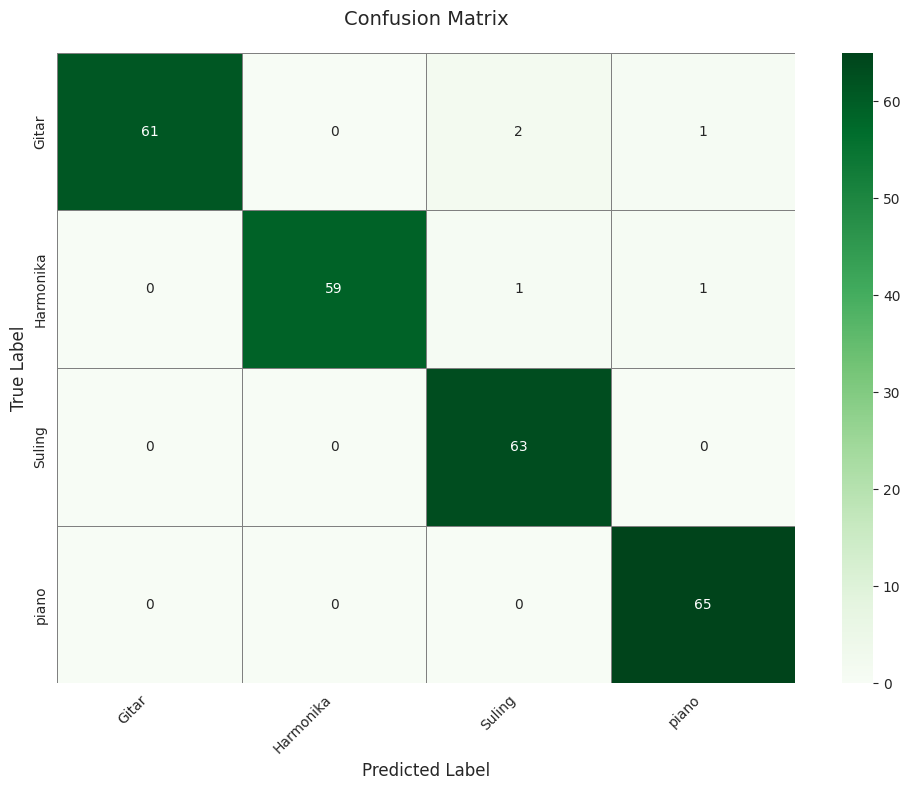

In [30]:
import matplotlib.cm as cm
# Menghitung confusion matrix
cm = confusion_matrix(y_test, pred)

# Normalisasi (opsional, hasil tetap sama jika normalize=False)
normalize = False  # Set True untuk menampilkan persentase
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='.2f' if normalize else 'd',  # Format: persen jika normalize, integer jika tidak
    cmap='Greens',                     # Ganti colormap: 'Oranges', 'Reds', 'Purples', dll.
    linewidths=0.5,                    # Tambahkan border antar sel
    linecolor='gray',
    xticklabels=test_images.class_indices.keys(),
    yticklabels=test_images.class_indices.keys()
)

# Atur judul dan label
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Rotasi label sumbu x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()  # Agar tidak ada teks yang terpotong
plt.show()

In [31]:
def get_img_array(img_path, size):
    # Memuat gambar dan mengubah ukuran gambar sesuai dengan ukuran yang ditentukan
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Menambahkan dimensi untuk mengubah array menjadi "batch" dengan ukuran "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Membuat model yang memetakan gambar input ke aktivasi dari layer konvolusi terakhir
    # serta output prediksi
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Menghitung gradien dari kelas yang diprediksi untuk gambar input
    # terhadap aktivasi layer konvolusi terakhir
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # Ini adalah gradien dari neuron output (kelas yang dipilih atau tertinggi)
    # terhadap feature map output dari layer konvolusi terakhir
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Ini adalah vektor dimana setiap entri adalah intensitas rata-rata dari gradien
    # di setiap channel feature map tertentu
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Mengalikan setiap channel dalam array feature map
    # dengan "seberapa penting channel ini" terhadap kelas yang diprediksi tertinggi
    # kemudian menjumlahkan semua channel untuk mendapatkan heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## Untuk tujuan visualisasi, kita juga akan menormalisasi heatmap antara 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Memuat gambar asli
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Menyusun ulang heatmap ke rentang 0-255
    heatmap = np.uint8(255 * heatmap)

    # Menggunakan colormap 'jet' untuk mewarnai heatmap
    jet = cm.get_cmap("jet")

    # Mengambil nilai RGB dari colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Membuat gambar dengan heatmap yang diberi warna RGB
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Menggabungkan heatmap dengan gambar asli
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Menyimpan gambar yang sudah digabungkan
    superimposed_img.save(cam_path)

    # Menampilkan Grad CAM
    # display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Menghapus softmax dari layer terakhir
model.layers[-1].activation = None

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_820']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
<ipython-input-31-1c46ef1df415>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


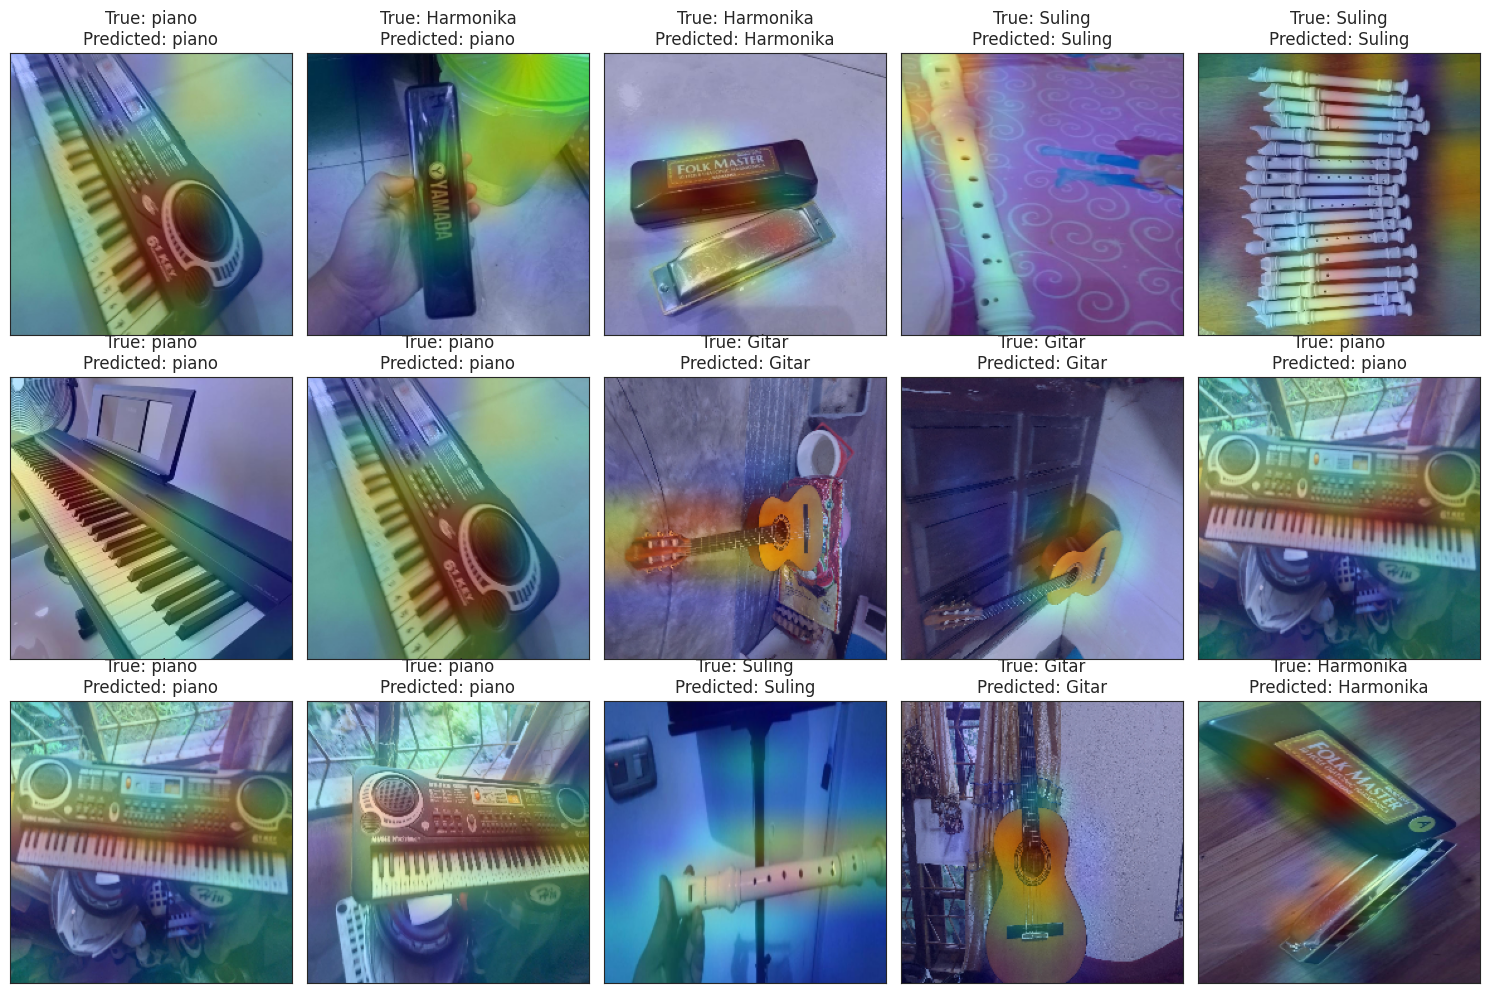

In [32]:
import matplotlib.cm as cm
# Tampilkan bagian gambar yang digunakan oleh jaringan saraf untuk mengklasifikasikan gambar
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (224, 224)

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)

    img_resized = cv2.resize(plt.imread(cam_path), resize_dim)

    ax.imshow(img_resized)
    ax.set_title(f"True: {test_df.Jenis.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")

plt.tight_layout()
plt.show()

Saving Untitled.jpg to Untitled.jpg


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 78.7MB/s]


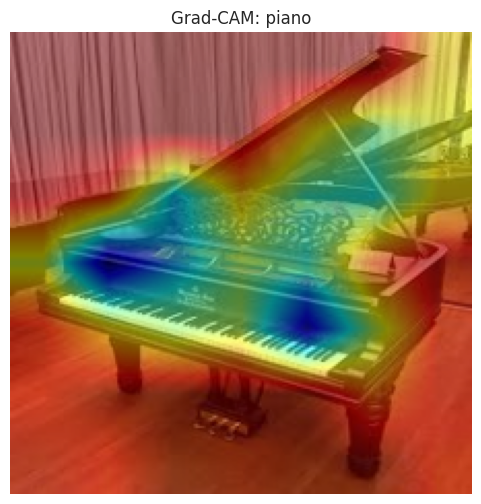

Predicted class index: 3
Predicted class name: piano
Output raw logits: tensor([[-0.3159, -0.0530, -0.1967,  0.2126]], grad_fn=<AddmmBackward0>)


In [33]:
# === Upload Gambar ===
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]  # Ambil nama file yang diupload otomatis

# === Import Library ===
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Setup Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Model MobileNetV2 ===
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)
num_classes = 4  # Ganti sesuai jumlah kelas
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)
model.eval()

# === Class Names ===
class_names = ['Suling', 'Harmonika', 'Gitar', 'piano']

# === Preprocessing Gambar ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# === Grad-CAM ===
def grad_cam(model, image_tensor, target_class):
    model.eval()
    gradients, activations = [], []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    final_conv = model.features[-1]
    f_handle = final_conv.register_forward_hook(forward_hook)
    b_handle = final_conv.register_full_backward_hook(backward_hook)

    output = model(image_tensor)
    model.zero_grad()
    class_loss = output[0][target_class]
    class_loss.backward()

    grads = gradients[0].detach().cpu().numpy()[0]
    acts = activations[0].detach().cpu().numpy()[0]
    weights = np.mean(grads, axis=(1, 2))

    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    f_handle.remove()
    b_handle.remove()
    return cam

# === Prediksi dan Tampilkan Grad-CAM ===
output = model(input_tensor)
pred_class = output.argmax(1).item()
heatmap = grad_cam(model, input_tensor, pred_class)

if heatmap is not None:
    img_np = np.array(img.resize((224, 224)))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img_np, 0.5, heatmap_colored, 0.5, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(overlayed_img)
    plt.title(f"Grad-CAM: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

    print("Predicted class index:", pred_class)
    print("Predicted class name:", class_names[pred_class])
print("Output raw logits:", output)